In [201]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, recall_score

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

In [2]:
car_review = pd.read_csv('car_review.csv', index_col=0)

In [3]:
car_review.head()

,Rating,Year,Review,Brand
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/


In [4]:
car_review.Rating.value_counts()

5    14704
4     3211
3      730
2      313
1      284
Name: Rating, dtype: int64

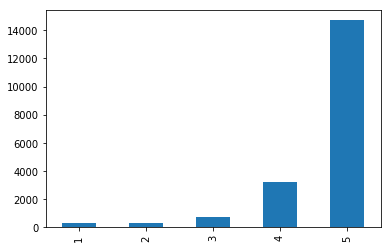

In [5]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

* Reviews are skewed towards positive

# Cleaning data and retrive features

### Car

In [6]:
car_review['Car'] = car_review.Brand.map(lambda x: x.split('/')[0])
car_review['Car_Year'] = car_review['Car'].map(lambda x: x.split('-')[-1])
car_review['Car_test'] = car_review['Car'].map(lambda x: x.split('-')[:-1])
car_review['Car_Make'] = car_review['Car_test'].map(lambda x: x[0])
car_review['Car_Model'] = car_review['Car_test'].map(lambda x: x[-1])

In [7]:
car_review.drop(['Car_test'], axis=1, inplace=True)

In [8]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger


### Reviews

In [9]:
car_review['Review'] = car_review['Review'].map(lambda x: x.rstrip().lstrip())

In [10]:
car_review['Review'].head()

1    This is what I've bought Saturday:\n2012 Dodge...
2    I just got my Special Order wiith my name on w...
3    About 2 months ago I purchased a new Dodge Cha...
4    We bought a tungsten metallic SXT-Plus Charger...
5    I have a 2012 Dodge Charger R/T Plus AWD in re...
Name: Review, dtype: object

### Date

In [11]:
from datetime import datetime

In [12]:
car_review['Review_Date'] = car_review['Year'].map(lambda x: 
                                                   datetime.strptime(x.split('\n')[-2].split('on')[-1].lstrip(), '%B %d, %Y'))
car_review['Review_Year'] = car_review['Review_Date'].map(lambda x: x.year)
car_review['Review_Month'] = car_review['Review_Date'].map(lambda x: x.month)
car_review['Review_Day'] = car_review['Review_Date'].map(lambda x: x.day)

In [13]:
car_review[['Review_Date', 'Review_Year', 'Review_Month', 'Review_Day']].head()

,Review_Date,Review_Year,Review_Month,Review_Day
1,2012-05-02,2012,5,2
2,2012-06-14,2012,6,14
3,2012-06-29,2012,6,29
4,2012-05-08,2012,5,8
5,2012-03-19,2012,3,19


### Car Age

In [14]:
int(car_review['Car_Year'][1])

2012

In [15]:
car_review['Car_Age'] = car_review['Review_Year'].map(lambda x: int(x))-car_review['Car_Year'].map(lambda x: int(x))

In [16]:
car_review['Car_Age'] = car_review['Car_Age'].map(lambda x: 0 if x==-1 else x)

In [17]:
car_review['Car_Age'].corr(car_review['Rating'])

-0.07932111336293686

There is a negative correlation between car age and rating which means that people will give newer car higher rating.

### Remove duplicate review
* There are some duplicate reviews in the dataset

In [18]:
car_review.shape

(19242, 13)

In [19]:
car_review.Review.nunique()

10821

In [20]:
car_review.Review.value_counts().head(5)

A solid compact sedan. I owned a Civic years ago, and I like the emergency brake redesign. The gas cap is gone, and the lid over the gas fill intake locks when the doors lock, and unlocks when the doors unlock. This makes a lot of sense.    52
I am very happy with my purchase. No buyers remorse at all. Fast, fun, reliable and comfortable! Would highly recommend this car to anyone. You will not find more bang for you buck.                                                            52
This is my first new car and I am happy with the comfort and look of the car.  The Civic Hatchback is great to handle and the technical aspects of the car are easy to understand.                                                               50
This car is great for you to travel with or just go out on the town with friends. This car feels great when you drive it around. The gas mileage is great also. I feel safe driving it.                                                          50
Excellent car. Excellent

In [21]:
car_review=car_review.drop_duplicates(subset=['Review'])

In [22]:
print('Number of unique reviews: ', car_review.Review.nunique())
print('Shape of the dataset: ', car_review.shape)

Number of unique reviews:  10821
Shape of the dataset:  (10821, 13)


In [23]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model,Review_Date,Review_Year,Review_Month,Review_Day,Car_Age
1,4,\n by JayeMaye\n ...,This is what I've bought Saturday:\n2012 Dodge...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-05-02,2012,5,2,0
2,5,\n by Female Driver\n ...,I just got my Special Order wiith my name on w...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-06-14,2012,6,14,0
3,5,\n by New Car Buyer\n ...,About 2 months ago I purchased a new Dodge Cha...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-06-29,2012,6,29,0
4,5,\n by KTisaPhillyPhan\n ...,We bought a tungsten metallic SXT-Plus Charger...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-05-08,2012,5,8,0
5,5,\n by I<3DODGE\n ...,I have a 2012 Dodge Charger R/T Plus AWD in re...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-03-19,2012,3,19,0


In [24]:
car_review.Rating.value_counts()

5    7815
4    1943
3     538
2     273
1     252
Name: Rating, dtype: int64

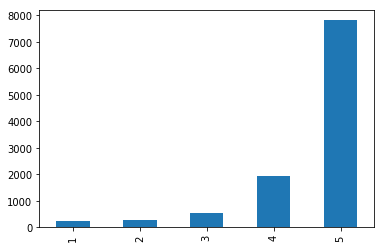

In [25]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

In [26]:
pd.crosstab(index=car_review.Rating, columns="count")/pd.crosstab(index=car_review.Rating, columns="count").sum()

col_0,count
Rating,
1,0.023288
2,0.025229
3,0.049718
4,0.179558
5,0.722207


### Create positive & negative tag 

In [27]:
car_review['tag'] = car_review['Rating'].map(lambda x:0 if x==5 else 1)

In [28]:
car_review['tag'].value_counts(sort=False)

0    7815
1    3006
Name: tag, dtype: int64

* I tag the reviews that the users not fully satisfied with the car.
#### 1: negative;
#### 0: positive.

# Split the data set

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
x = car_review.Review
y = car_review.tag
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, random_state=10, test_size=0.2)

## Doc2Vec

In [114]:
size = 100

In [110]:
def labelized_object(sentences,label):
    result = []
    prefix = label
    for i, t in zip(sentences.index, sentences):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result

In [117]:
def get_vectors(model, corpus, size=100):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [111]:
x_w2v = labelized_object(x, 'all')

/Users/lana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [296]:
#### concat two models   
def get_concat_vectors(model1,model2, corpus, size=200):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

* Other methods

In [295]:
def grid(parameters, model, train_x, train_y):
    
    kfold = KFold(n_splits=3, random_state=10)
    gs = GridSearchCV(model, parameters, cv=kfold, scoring= 'recall')
    
    print("Performing grid search...")
    t0 = time()
    gs.fit(train_x, train_y)
    t1 = time() 
    print("Done in %0.3fs" % (t1 - t0))
    
    print("Best recall: %0.3f" % gs.best_score_)
    print("Best parameters:")
    best_parameters = gs.best_estimator_.get_params()
    print(best_parameters)
    

def model(model, trainx, trainy, testx, testy):
    model = model.fit(trainx, trainy)
    predict = model.predict(testx)
    
    fpr_train, tpr_train,_=roc_curve(trainy, model.predict(trainx))
    auc_train=auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test,_=roc_curve(testy, predict)
    auc_test=auc(fpr_test, tpr_test)
    
    print('AUC(Train): {:.4f}'.format(auc_train))
    print('AUC(Test):  {:.4f}'.format(auc_test))
    print ("TRAIN Accuracy:   %0.3f" % accuracy_score(trainy, model.predict(trainx)))
    print ("TEST Accuracy:   %0.3f" % accuracy_score(testy, predict))
    
    cm = confusion_matrix(testy, predict, labels = [0, 1])
    print('Confusion matrix, without normalization:')
    print(cm)
    print("Normalized confusion matrix:")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    print(classification_report(testy,predict))

### 1. DBOW

In [118]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, size=size, negative=5, min_count=2,
                        workers=cores, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(x_w2v)])

/Users/lana/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 10821/10821 [00:00<00:00, 2306813.91it/s]


In [119]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(x_w2v)]), 
                        total_examples=len(x_w2v), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 10821/10821 [00:00<00:00, 2599310.67it/s]


CPU times: user 53.3 s, sys: 3.95 s, total: 57.2 s
Wall time: 31.4 s


In [120]:
train_vecs_dbow = get_vectors(model_dbow, Xtrain, 100)
test_vecs_dbow = get_vectors(model_dbow, Xtest, 100)

#### 1.1 Logistic Regression

In [128]:
model(LogisticRegression(C=10), train_vecs_dbow, ytrain, test_vecs_dbow, ytest)

AUC(Train): 0.7071
AUC(Test):  0.7016
TRAIN Accuracy:   0.804
TEST Accuracy:   0.803
Confusion matrix, without normalization:
[[1457  126]
 [ 301  281]]
Normalized confusion matrix:
[[0.9204043  0.0795957 ]
 [0.51718213 0.48281787]]
             precision    recall  f1-score   support

          0       0.83      0.92      0.87      1583
          1       0.69      0.48      0.57       582

avg / total       0.79      0.80      0.79      2165



#### 1.2 Linear SVC

In [148]:
model(LinearSVC(), train_vecs_dbow, ytrain, test_vecs_dbow, ytest)

AUC(Train): 0.7032
AUC(Test):  0.7001
TRAIN Accuracy:   0.804
TEST Accuracy:   0.807
Confusion matrix, without normalization:
[[1474  109]
 [ 309  273]]
Normalized confusion matrix:
[[0.9311434  0.0688566 ]
 [0.53092784 0.46907216]]
             precision    recall  f1-score   support

          0       0.83      0.93      0.88      1583
          1       0.71      0.47      0.57       582

avg / total       0.80      0.81      0.79      2165



#### 1.3 Random Forest

In [162]:
model(RandomForestClassifier(max_depth = 15, n_estimators=10), train_vecs_dbow, ytrain, test_vecs_dbow, ytest)

AUC(Train): 0.9160
AUC(Test):  0.6038
TRAIN Accuracy:   0.952
TEST Accuracy:   0.749
Confusion matrix, without normalization:
[[1452  131]
 [ 413  169]]
Normalized confusion matrix:
[[0.91724574 0.08275426]
 [0.70962199 0.29037801]]
             precision    recall  f1-score   support

          0       0.78      0.92      0.84      1583
          1       0.56      0.29      0.38       582

avg / total       0.72      0.75      0.72      2165



#### 1.4 Neural Network

In [229]:
np.random.seed(22)
nn_d2v = Sequential()
nn_d2v.add(Dense(128, activation='relu', input_dim=100))
nn_d2v.add(Dense(1, activation='sigmoid'))
nn_d2v.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

nn_d2v.fit(train_vecs_dbow, ytrain,
                 validation_split=0.1, epochs=10, batch_size=32, verbose=2)

Train on 7790 samples, validate on 866 samples
Epoch 1/10
 - 1s - loss: 0.4950 - acc: 0.7698 - val_loss: 0.4656 - val_acc: 0.7968
Epoch 2/10
 - 1s - loss: 0.4491 - acc: 0.8053 - val_loss: 0.4554 - val_acc: 0.8002
Epoch 3/10
 - 1s - loss: 0.4331 - acc: 0.8109 - val_loss: 0.4531 - val_acc: 0.8025
Epoch 4/10
 - 1s - loss: 0.4187 - acc: 0.8208 - val_loss: 0.4525 - val_acc: 0.8048
Epoch 5/10
 - 1s - loss: 0.4042 - acc: 0.8288 - val_loss: 0.4619 - val_acc: 0.7956
Epoch 6/10
 - 1s - loss: 0.3883 - acc: 0.8367 - val_loss: 0.4606 - val_acc: 0.7968
Epoch 7/10
 - 1s - loss: 0.3694 - acc: 0.8467 - val_loss: 0.4565 - val_acc: 0.7979
Epoch 8/10
 - 1s - loss: 0.3504 - acc: 0.8542 - val_loss: 0.4688 - val_acc: 0.7921
Epoch 9/10
 - 1s - loss: 0.3324 - acc: 0.8652 - val_loss: 0.4651 - val_acc: 0.8014
Epoch 10/10
 - 1s - loss: 0.3109 - acc: 0.8768 - val_loss: 0.4690 - val_acc: 0.7968


In [230]:
nn_scores = nn_d2v.evaluate(test_vecs_dbow, ytest)
print('loss     = ', nn_scores[0])
print('accuracy = ', nn_scores[1])

2165/2165 [==============================] - 0s 39us/step
loss     =  0.47235153453729994
accuracy =  0.7958429562852785


In [267]:
nn_ytrain=nn_d2v.predict(train_vecs_dbow)
nn_ytest=nn_d2v.predict(test_vecs_dbow)
pre_testy2 = [0 if i <0.5 else 1 for i in nn_ytest.reshape(len(nn_ytest),)]
fpr_test, tpr_test,_=roc_curve(ytest, pre_testy2)
print('AUC(Test):  {:.4f}'.format(auc(fpr_test, tpr_test)))
print ("TEST Accuracy:   %0.3f" % accuracy_score(ytest, pre_testy2))
confusion_matrix(ytest, pre_testy2, labels = [0, 1])

AUC(Test):  0.6925
TEST Accuracy:   0.796


array([[1450,  133],
       [ 309,  273]])

### 2. DMC

In [235]:
cores = multiprocessing.cpu_count()
model_dmc = Doc2Vec(dm=1, dm_concat=1, size=100, window=2, 
                       negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_dmc.build_vocab([x for x in tqdm(x_w2v)])

/Users/lana/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 10821/10821 [00:00<00:00, 2395574.98it/s]


In [236]:
%%time
for epoch in range(30):
    model_dmc.train(utils.shuffle([x for x in tqdm(x_w2v)]), 
                    total_examples=len(x_w2v), epochs=1)
    model_dmc.alpha -= 0.002
    model_dmc.min_alpha = model_dmc.alpha

100%|██████████| 10821/10821 [00:00<00:00, 2606176.49it/s]


CPU times: user 1min 34s, sys: 4.57 s, total: 1min 39s
Wall time: 41.8 s


In [237]:
model_dmc.most_similar('good')

/Users/lana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/lana/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('great', 0.6790786981582642),
 ('decent', 0.6758978962898254),
 ('competent', 0.6072064638137817),
 ('speedy', 0.6067125797271729),
 ('bad', 0.5732701420783997),
 ('turbo-charged', 0.5629264116287231),
 ('trouble-free', 0.5626224279403687),
 ('sharp', 0.5624820590019226),
 ('nice', 0.5557277202606201),
 ('best-in-class', 0.548293948173523)]

In [242]:
model_dmc.most_similar('honda')

/Users/lana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/lana/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Honda', 0.5836304426193237),
 ('Infiniti', 0.5324746370315552),
 ('Maxima,', 0.5094331502914429),
 ('Ford', 0.5001115798950195),
 ('Volkswagen.', 0.4851771295070648),
 ('Jimmy', 0.48162344098091125),
 ('gmc', 0.4798303246498108),
 ('Chrysler', 0.47966504096984863),
 ('Toyota', 0.4795268476009369),
 ('SL,', 0.47821295261383057)]

* The model successfully catches the comparative form of words in the reviews

In [243]:
train_vecs_dmc = get_vectors(model_dmc, Xtrain, 100)
test_vecs_dmc = get_vectors(model_dmc, Xtest, 100)

#### 2.1 Logistic Regression

In [246]:
grid({'C': [0.001,0.01,0.1,1,10,100]}, LogisticRegression(), train_vecs_dmc, ytrain)

Performing grid search...
Done in 1.835s
Best recall: 0.321
Best parameters:
{'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [247]:
model(LogisticRegression(C = 10), train_vecs_dmc, ytrain, test_vecs_dmc, ytest)

AUC(Train): 0.6332
AUC(Test):  0.6459
TRAIN Accuracy:   0.766
TEST Accuracy:   0.780
Confusion matrix, without normalization:
[[1482  101]
 [ 375  207]]
Normalized confusion matrix:
[[0.93619709 0.06380291]
 [0.6443299  0.3556701 ]]
             precision    recall  f1-score   support

          0       0.80      0.94      0.86      1583
          1       0.67      0.36      0.47       582

avg / total       0.76      0.78      0.76      2165



#### 2.2 Linear SVC

In [249]:
model(LinearSVC(), train_vecs_dmc, ytrain, test_vecs_dmc, ytest)

AUC(Train): 0.6271
AUC(Test):  0.6390
TRAIN Accuracy:   0.767
TEST Accuracy:   0.781
Confusion matrix, without normalization:
[[1498   85]
 [ 389  193]]
Normalized confusion matrix:
[[0.94630449 0.05369551]
 [0.66838488 0.33161512]]
             precision    recall  f1-score   support

          0       0.79      0.95      0.86      1583
          1       0.69      0.33      0.45       582

avg / total       0.77      0.78      0.75      2165



#### 2.3 Random Forest

In [254]:
model(RandomForestClassifier(n_estimators=10, max_depth=20), 
      train_vecs_dmc, ytrain, test_vecs_dmc, ytest)

AUC(Train): 0.9378
AUC(Test):  0.5805
TRAIN Accuracy:   0.964
TEST Accuracy:   0.723
Confusion matrix, without normalization:
[[1408  175]
 [ 424  158]]
Normalized confusion matrix:
[[0.88945041 0.11054959]
 [0.72852234 0.27147766]]
             precision    recall  f1-score   support

          0       0.77      0.89      0.82      1583
          1       0.47      0.27      0.35       582

avg / total       0.69      0.72      0.70      2165



#### 2.4 neural network

In [268]:
%%time
np.random.seed(5)
model_d2v_02 = Sequential()
model_d2v_02.add(Dense(128, activation='relu', input_dim=100))
model_d2v_02.add(Dense(1, activation='sigmoid'))
model_d2v_02.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_02.fit(train_vecs_dmc, ytrain, validation_split=0.1, 
                 epochs=10, batch_size=32, verbose=2)

Train on 7790 samples, validate on 866 samples
Epoch 1/10
 - 1s - loss: 0.5547 - acc: 0.7386 - val_loss: 0.5331 - val_acc: 0.7540
Epoch 2/10
 - 1s - loss: 0.5079 - acc: 0.7646 - val_loss: 0.5237 - val_acc: 0.7598
Epoch 3/10
 - 1s - loss: 0.4929 - acc: 0.7727 - val_loss: 0.5202 - val_acc: 0.7633
Epoch 4/10
 - 1s - loss: 0.4791 - acc: 0.7823 - val_loss: 0.5169 - val_acc: 0.7771
Epoch 5/10
 - 1s - loss: 0.4668 - acc: 0.7887 - val_loss: 0.5197 - val_acc: 0.7702
Epoch 6/10
 - 1s - loss: 0.4540 - acc: 0.7947 - val_loss: 0.5227 - val_acc: 0.7702
Epoch 7/10
 - 1s - loss: 0.4410 - acc: 0.8056 - val_loss: 0.5216 - val_acc: 0.7587
Epoch 8/10
 - 1s - loss: 0.4270 - acc: 0.8151 - val_loss: 0.5277 - val_acc: 0.7656
Epoch 9/10
 - 1s - loss: 0.4128 - acc: 0.8227 - val_loss: 0.5310 - val_acc: 0.7667
Epoch 10/10
 - 1s - loss: 0.3993 - acc: 0.8311 - val_loss: 0.5365 - val_acc: 0.7425
CPU times: user 9.73 s, sys: 3.77 s, total: 13.5 s
Wall time: 9.05 s


In [269]:
nn_scores = model_d2v_02.evaluate(test_vecs_dmc, ytest)
print('loss     = ', nn_scores[0])
print('accuracy = ', nn_scores[1])

2165/2165 [==============================] - 0s 34us/step
loss     =  0.5127916470135607
accuracy =  0.7648960741232504


In [270]:
nn_ytrain=model_d2v_02.predict(train_vecs_dmc)
nn_ytest=model_d2v_02.predict(test_vecs_dmc)
pre_testy2 = [0 if i <0.5 else 1 for i in nn_ytest.reshape(len(nn_ytest),)]
fpr_test, tpr_test,_=roc_curve(ytest, pre_testy2)
print('AUC(Test):  {:.4f}'.format(auc(fpr_test, tpr_test)))
print ("TEST Accuracy:   %0.3f" % accuracy_score(ytest, pre_testy2))
confusion_matrix(ytest, pre_testy2, labels = [0, 1])

AUC(Test):  0.6480
TEST Accuracy:   0.765


array([[1426,  157],
       [ 352,  230]])

### 3. DMM 

In [271]:
cores = multiprocessing.cpu_count()
model_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, 
                    min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(x_w2v)])

/Users/lana/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 10821/10821 [00:00<00:00, 2206122.76it/s]


In [272]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(x_w2v)]), total_examples=len(x_w2v), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 10821/10821 [00:00<00:00, 2575854.91it/s]


CPU times: user 1min 15s, sys: 10.7 s, total: 1min 25s
Wall time: 44.1 s


In [273]:
model_dmm.most_similar('honda')

/Users/lana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/lana/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Honda', 0.5153903961181641),
 ('Nissan', 0.4130866825580597),
 ('entity', 0.4121984839439392),
 ('Corollas,', 0.4014264941215515),
 ('Mazda3,', 0.397941529750824),
 ('nissan', 0.3907093405723572),
 ('Maxima,', 0.372851699590683),
 ('BAM!', 0.3682459890842438),
 ('corolla', 0.36656057834625244),
 ('1999', 0.35308700799942017)]

In [274]:
train_vecs_dmm = get_vectors(model_dmm, Xtrain, 100)
test_vecs_dmm = get_vectors(model_dmm, Xtest, 100)

#### 3.1 Logistic Regression

In [276]:
model(LogisticRegression(C = 10), train_vecs_dmm, ytrain, test_vecs_dmc, ytest)

AUC(Train): 0.6766
AUC(Test):  0.5157
TRAIN Accuracy:   0.792
TEST Accuracy:   0.685
Confusion matrix, without normalization:
[[1396  187]
 [ 495   87]]
Normalized confusion matrix:
[[0.88186987 0.11813013]
 [0.85051546 0.14948454]]
             precision    recall  f1-score   support

          0       0.74      0.88      0.80      1583
          1       0.32      0.15      0.20       582

avg / total       0.63      0.68      0.64      2165



#### 3.2 Linear SVC

In [277]:
model(LinearSVC(), train_vecs_dmm, ytrain, test_vecs_dmm, ytest)

AUC(Train): 0.6702
AUC(Test):  0.6595
TRAIN Accuracy:   0.791
TEST Accuracy:   0.791
Confusion matrix, without normalization:
[[1495   88]
 [ 364  218]]
Normalized confusion matrix:
[[0.94440935 0.05559065]
 [0.62542955 0.37457045]]
             precision    recall  f1-score   support

          0       0.80      0.94      0.87      1583
          1       0.71      0.37      0.49       582

avg / total       0.78      0.79      0.77      2165



#### 3.3 Random Rorest

In [278]:
model(RandomForestClassifier(), 
      train_vecs_dmm, ytrain, test_vecs_dmm, ytest)

AUC(Train): 0.9593
AUC(Test):  0.5802
TRAIN Accuracy:   0.977
TEST Accuracy:   0.740
Confusion matrix, without normalization:
[[1467  116]
 [ 446  136]]
Normalized confusion matrix:
[[0.92672142 0.07327858]
 [0.76632302 0.23367698]]
             precision    recall  f1-score   support

          0       0.77      0.93      0.84      1583
          1       0.54      0.23      0.33       582

avg / total       0.71      0.74      0.70      2165



#### 3.4 Neural Network

In [292]:
%%time
np.random.seed(5)
model_d2v_03 = Sequential()
model_d2v_03.add(Dense(64, activation='relu', input_dim=100))
model_d2v_03.add(Dense(1, activation='sigmoid'))
model_d2v_03.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_03.fit(train_vecs_dmm, ytrain, validation_split=0.1, 
                 epochs=10, batch_size=32, verbose=2)

Train on 7790 samples, validate on 866 samples
Epoch 1/10
 - 1s - loss: 0.5156 - acc: 0.7677 - val_loss: 0.4715 - val_acc: 0.7898
Epoch 2/10
 - 1s - loss: 0.4718 - acc: 0.7946 - val_loss: 0.4650 - val_acc: 0.7875
Epoch 3/10
 - 1s - loss: 0.4579 - acc: 0.8006 - val_loss: 0.4638 - val_acc: 0.7910
Epoch 4/10
 - 1s - loss: 0.4454 - acc: 0.8055 - val_loss: 0.4653 - val_acc: 0.7864
Epoch 5/10
 - 1s - loss: 0.4317 - acc: 0.8140 - val_loss: 0.4666 - val_acc: 0.7864
Epoch 6/10
 - 1s - loss: 0.4188 - acc: 0.8191 - val_loss: 0.4664 - val_acc: 0.7910
Epoch 7/10
 - 1s - loss: 0.4062 - acc: 0.8302 - val_loss: 0.4683 - val_acc: 0.7875
Epoch 8/10
 - 1s - loss: 0.3919 - acc: 0.8370 - val_loss: 0.4701 - val_acc: 0.7794
Epoch 9/10
 - 1s - loss: 0.3775 - acc: 0.8440 - val_loss: 0.4778 - val_acc: 0.7898
Epoch 10/10
 - 1s - loss: 0.3646 - acc: 0.8503 - val_loss: 0.4821 - val_acc: 0.7783
CPU times: user 9.35 s, sys: 3.89 s, total: 13.2 s
Wall time: 8.99 s


In [293]:
nn_scores = model_d2v_03.evaluate(test_vecs_dmm, ytest)
print('loss     = ', nn_scores[0])
print('accuracy = ', nn_scores[1])

2165/2165 [==============================] - 0s 43us/step
loss     =  0.4968371925673364
accuracy =  0.7736720555649068


In [294]:
nn_ytrain=model_d2v_03.predict(train_vecs_dmm)
nn_ytest=model_d2v_03.predict(test_vecs_dmm)
pre_testy2 = [0 if i <0.5 else 1 for i in nn_ytest.reshape(len(nn_ytest),)]
fpr_test, tpr_test,_=roc_curve(ytest, pre_testy2)
print('AUC(Test):  {:.4f}'.format(auc(fpr_test, tpr_test)))
print ("TEST Accuracy:   %0.3f" % accuracy_score(ytest, pre_testy2))
confusion_matrix(ytest, pre_testy2, labels = [0, 1])

AUC(Test):  0.6703
TEST Accuracy:   0.774


array([[1415,  168],
       [ 322,  260]])

### 4. DBOW + DMC

In [311]:
train_vecs_dbow_dmc = get_concat_vectors(model_dbow,model_dmc, Xtrain, 200)
test_vecs_dbow_dmc = get_concat_vectors(model_dbow,model_dmc, Xtest, 200)

In [312]:
model(LogisticRegression(), train_vecs_dbow_dmc, ytrain, test_vecs_dbow_dmc, ytest)

AUC(Train): 0.7144
AUC(Test):  0.6947
TRAIN Accuracy:   0.808
TEST Accuracy:   0.799
Confusion matrix, without normalization:
[[1457  126]
 [ 309  273]]
Normalized confusion matrix:
[[0.9204043  0.0795957 ]
 [0.53092784 0.46907216]]
             precision    recall  f1-score   support

          0       0.83      0.92      0.87      1583
          1       0.68      0.47      0.56       582

avg / total       0.79      0.80      0.79      2165



In [313]:
model(LinearSVC(), train_vecs_dbow_dmc, ytrain, test_vecs_dbow_dmc, ytest)

AUC(Train): 0.7078
AUC(Test):  0.6953
TRAIN Accuracy:   0.807
TEST Accuracy:   0.802
Confusion matrix, without normalization:
[[1467  116]
 [ 312  270]]
Normalized confusion matrix:
[[0.92672142 0.07327858]
 [0.53608247 0.46391753]]
             precision    recall  f1-score   support

          0       0.82      0.93      0.87      1583
          1       0.70      0.46      0.56       582

avg / total       0.79      0.80      0.79      2165



In [314]:
model(RandomForestClassifier(), 
      train_vecs_dbow_dmc, ytrain, test_vecs_dbow_dmc, ytest)

AUC(Train): 0.9640
AUC(Test):  0.5892
TRAIN Accuracy:   0.980
TEST Accuracy:   0.746
Confusion matrix, without normalization:
[[1471  112]
 [ 437  145]]
Normalized confusion matrix:
[[0.92924826 0.07075174]
 [0.75085911 0.24914089]]
             precision    recall  f1-score   support

          0       0.77      0.93      0.84      1583
          1       0.56      0.25      0.35       582

avg / total       0.72      0.75      0.71      2165



In [343]:
%%time
np.random.seed(10)
model_d2v_04 = Sequential()
model_d2v_04.add(Dense(64, activation='relu', input_dim=200))
model_d2v_04.add(Dense(1, activation='sigmoid'))
model_d2v_04.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_04.fit(train_vecs_dbow_dmc, ytrain, validation_split = 0.1,
                 epochs=5, batch_size=32, verbose=2)

Train on 7790 samples, validate on 866 samples
Epoch 1/5
 - 2s - loss: 0.4965 - acc: 0.7724 - val_loss: 0.4719 - val_acc: 0.7945
Epoch 2/5
 - 1s - loss: 0.4461 - acc: 0.8032 - val_loss: 0.4669 - val_acc: 0.7979
Epoch 3/5
 - 1s - loss: 0.4290 - acc: 0.8134 - val_loss: 0.4667 - val_acc: 0.8002
Epoch 4/5
 - 1s - loss: 0.4113 - acc: 0.8226 - val_loss: 0.4733 - val_acc: 0.7921
Epoch 5/5
 - 1s - loss: 0.3937 - acc: 0.8332 - val_loss: 0.4754 - val_acc: 0.7898
CPU times: user 6.3 s, sys: 1.94 s, total: 8.24 s
Wall time: 6.11 s


In [344]:
nn_scores = model_d2v_04.evaluate(test_vecs_dbow_dmc, ytest)
print('loss     = ', nn_scores[0])
print('accuracy = ', nn_scores[1])

2165/2165 [==============================] - 0s 58us/step
loss     =  0.45080362109609345
accuracy =  0.8036951502806595


In [345]:
nn_ytrain=model_d2v_04.predict(train_vecs_dbow_dmc)
nn_ytest=model_d2v_04.predict(test_vecs_dbow_dmc)
pre_testy2 = [0 if i <0.5 else 1 for i in nn_ytest.reshape(len(nn_ytest),)]
fpr_test, tpr_test,_=roc_curve(ytest, pre_testy2)
print('AUC(Test):  {:.4f}'.format(auc(fpr_test, tpr_test)))
print ("TEST Accuracy:   %0.3f" % accuracy_score(ytest, pre_testy2))
confusion_matrix(ytest, pre_testy2, labels = [0, 1])

AUC(Test):  0.6946
TEST Accuracy:   0.804


array([[1473,  110],
       [ 315,  267]])

### 5. DBOW + DMM

In [315]:
train_vecs_dbow_dmm = get_concat_vectors(model_dbow,model_dmm, Xtrain, 200)
test_vecs_dbow_dmm = get_concat_vectors(model_dbow,model_dmm, Xtest, 200)

In [316]:
model(LogisticRegression(), train_vecs_dbow_dmm, ytrain, test_vecs_dbow_dmm, ytest)

AUC(Train): 0.7136
AUC(Test):  0.7040
TRAIN Accuracy:   0.809
TEST Accuracy:   0.808
Confusion matrix, without normalization:
[[1470  113]
 [ 303  279]]
Normalized confusion matrix:
[[0.92861655 0.07138345]
 [0.52061856 0.47938144]]
             precision    recall  f1-score   support

          0       0.83      0.93      0.88      1583
          1       0.71      0.48      0.57       582

avg / total       0.80      0.81      0.79      2165



In [319]:
model(LinearSVC(), train_vecs_dbow_dmm, ytrain, test_vecs_dbow_dmm, ytest)

AUC(Train): 0.7049
AUC(Test):  0.6960
TRAIN Accuracy:   0.808
TEST Accuracy:   0.806
Confusion matrix, without normalization:
[[1480  103]
 [ 316  266]]
Normalized confusion matrix:
[[0.93493367 0.06506633]
 [0.54295533 0.45704467]]
             precision    recall  f1-score   support

          0       0.82      0.93      0.88      1583
          1       0.72      0.46      0.56       582

avg / total       0.80      0.81      0.79      2165



In [320]:
model(RandomForestClassifier(), 
      train_vecs_dbow_dmm, ytrain, test_vecs_dbow_dmm, ytest)

AUC(Train): 0.9642
AUC(Test):  0.5819
TRAIN Accuracy:   0.980
TEST Accuracy:   0.741
Confusion matrix, without normalization:
[[1467  116]
 [ 444  138]]
Normalized confusion matrix:
[[0.92672142 0.07327858]
 [0.7628866  0.2371134 ]]
             precision    recall  f1-score   support

          0       0.77      0.93      0.84      1583
          1       0.54      0.24      0.33       582

avg / total       0.71      0.74      0.70      2165



In [340]:
%%time
np.random.seed(10)
model_d2v_05 = Sequential()
model_d2v_05.add(Dense(64, activation='relu', input_dim=200))
model_d2v_05.add(Dense(1, activation='sigmoid'))
model_d2v_05.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_d2v_05.fit(train_vecs_dbow_dmm, ytrain, validation_split = 0.1,
                 epochs=5, batch_size=32, verbose=2)

Train on 7790 samples, validate on 866 samples
Epoch 1/5
 - 2s - loss: 0.4930 - acc: 0.7751 - val_loss: 0.4590 - val_acc: 0.7921
Epoch 2/5
 - 1s - loss: 0.4444 - acc: 0.8051 - val_loss: 0.4494 - val_acc: 0.8037
Epoch 3/5
 - 1s - loss: 0.4237 - acc: 0.8167 - val_loss: 0.4557 - val_acc: 0.8025
Epoch 4/5
 - 1s - loss: 0.4027 - acc: 0.8303 - val_loss: 0.4582 - val_acc: 0.8014
Epoch 5/5
 - 1s - loss: 0.3814 - acc: 0.8389 - val_loss: 0.4605 - val_acc: 0.7991
CPU times: user 5.95 s, sys: 1.98 s, total: 7.94 s
Wall time: 5.75 s


In [341]:
nn_scores = model_d2v_05.evaluate(test_vecs_dbow_dmm, ytest)
print('loss     = ', nn_scores[0])
print('accuracy = ', nn_scores[1])

2165/2165 [==============================] - 0s 60us/step
loss     =  0.45028543499821055
accuracy =  0.7986143189269456


In [342]:
nn_ytrain=model_d2v_05.predict(train_vecs_dbow_dmm)
nn_ytest=model_d2v_05.predict(test_vecs_dbow_dmm)
pre_testy2 = [0 if i <0.5 else 1 for i in nn_ytest.reshape(len(nn_ytest),)]
fpr_test, tpr_test,_=roc_curve(ytest, pre_testy2)
print('AUC(Test):  {:.4f}'.format(auc(fpr_test, tpr_test)))
print ("TEST Accuracy:   %0.3f" % accuracy_score(ytest, pre_testy2))
confusion_matrix(ytest, pre_testy2, labels = [0, 1])

AUC(Test):  0.6841
TEST Accuracy:   0.799


array([[1475,  108],
       [ 328,  254]])

## The best performance preprocessing method + algorithm is :
* Distributed Bag of Words + Logistic Regression Classifier